# GIS and Python - Lunar Edition

Austin Godber  
@godber

DesertPy - 2/24/2016

# Setup

Install Anaconda, then the `anaconda-client` if you don't have it, then install one of the following conda environments:

```
conda env create godber/mmmpy_2016-02-05_v0_linux
conda env create godber/mmpy_2016-02-21_v0_Darwin
```

# Emergency Quick Fix

I later found missing dependencies in the above environments.  Run the following commands to resolve:

```
conda install geos=3.3.3
```

# Quick Overview of GIS Concepts

  * Raster Data
  * Vector Data
  * Projection/Coordinate System

# Raster

<img src="raster_dataset.png" width=250px style="float:right;">

"A raster dataset is composed of rows (running across) and columns (running down) of pixels (also know as cells). Each pixel represents a geographical region, and the value in that pixel represents some characteristic of that region." - QGIS Docs



# Vector Data

<img src="vector_data.png" width=250px style="float:right;">

"A vector feature has its shape represented using geometry. The geometry is made up of one or more interconnected vertices. A vertex describes a position in space using an X, Y and optionally Z axis." - QGIS Docs



# Projection / Coordinate System

<img src="geographic_crs.png" width=250px style="float:right;">

"Map projections try to portray the surface of the earth or a portion of the earth on a flat piece of paper or computer screen. A coordinate reference system (CRS) then defines, with the help of coordinates, how the two-dimensional, projected map in your GIS is related to real places on the earth." - QGIS Docs

# Lunar Data Sources

The experts at LROC have us covered: http://lroc.sese.asu.edu/

Specifically we will be looking at their reduced or "RDR" products which can be found here:

http://wms.lroc.asu.edu/lroc/rdr_product_select#_ui-id-2

We need a sample of each of these types

  * image raster
  * DEM raster
  * shapefiles
  * csv lat/lon

Run the included utility script to get all of the data needed for the notebook.  This assumes you have `wget` and `unzip` installed on Linux or Mac.

In [32]:
!bash ./getdata.sh

File 'WAC_GLD100_P900S0000_128P.IMG' already there; not retrieving.

File 'WAC_GLOBAL_P900S0000_128P.IMG' already there; not retrieving.

File 'LROC_GLOBAL_MARE.ZIP' already there; not retrieving.

Archive:  ../LROC_GLOBAL_MARE.ZIP


In [33]:
ls -l *IMG global_mare/

-rw-r--r--  1 godber  staff  123606364 Sep  7 19:03 WAC_GLD100_P900S0000_128P.IMG
-rw-r--r--  1 godber  staff  247212728 Sep  7 19:52 WAC_GLOBAL_P900S0000_128P.IMG

global_mare/:
total 14400
-rw-r--r--  1 godber  staff    60054 Dec  4  2013 LROC_GLOBAL_MARE.DBF
-rw-r--r--  1 godber  staff      155 Dec  4  2013 LROC_GLOBAL_MARE.PRJ
-rw-r--r--  1 godber  staff     6900 Dec  4  2013 LROC_GLOBAL_MARE.SBN
-rw-r--r--  1 godber  staff  7280280 Dec  4  2013 LROC_GLOBAL_MARE.SHP
-rw-r--r--  1 godber  staff     6742 Dec 11  2013 LROC_GLOBAL_MARE.SHP.XML
-rw-r--r--  1 godber  staff     5252 Dec  4  2013 LROC_GLOBAL_MARE.SHX


* Lunar South Pole Image
  * http://wms.lroc.asu.edu/lroc/view_rdr_product/WAC_GLOBAL_P900S0000_128P
  * WAC_GLOBAL_P900S0000_128P.IMG
* Lunar South Pole Elevation
  * http://wms.lroc.asu.edu/lroc/view_rdr_product/WAC_GLD100_P900S0000_128P
  * WAC_GLD100_P900S0000_128P.IMG
* Zip file containing shp, dbf, shx and prj files for lunar global mare boundaries - (5.53 MB)
  * http://wms.lroc.asu.edu/lroc/view_rdr/SHAPEFILE_LUNAR_MARE

# Python GIS Tools

* GDAL - C library with Python Interface
* OSGEO - Part of GDAL
* Matplotlib (Basemap)

Of course, `numpy` and `pandas` will be useful as well.

So, let's import some stuff.

In [34]:
%matplotlib inline
import struct
from itertools import repeat

import gdal
import numpy as np
import pandas as pd
from osgeo import osr
import matplotlib.pyplot as plt

# Doing things

# ... and stuff

# Open and display image raster data


In [35]:
lunar_img_ds = gdal.Open('WAC_GLOBAL_P900S0000_128P.IMG')
lunar_img_ds.RasterCount, lunar_img_ds.RasterXSize, lunar_img_ds.RasterYSize

(1, 7861, 7861)

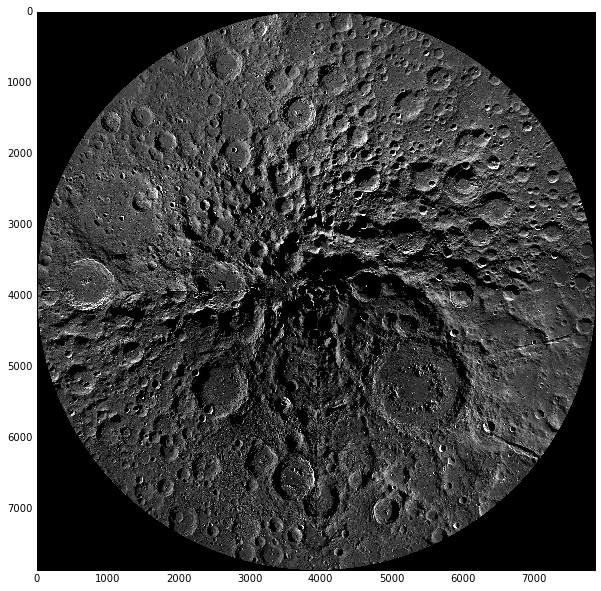

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(lunar_img_ds.GetRasterBand(1).ReadAsArray(
    ), cmap='gray', clim=(0.0,0.2))

# Open and display DEM/DTM (elevation) raster data

In [6]:
lunar_elev_ds = gdal.Open('WAC_GLD100_P900S0000_128P.IMG')
lunar_elev_ds.RasterCount, lunar_img_ds.RasterXSize, lunar_img_ds.RasterYSize

(1, 7861, 7861)

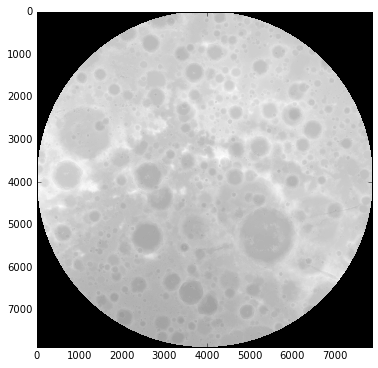

In [37]:
fig, ax = plt.subplots(figsize=(6,6))
ax.imshow(lunar_elev_ds.GetRasterBand(1).ReadAsArray(), cmap='gray')

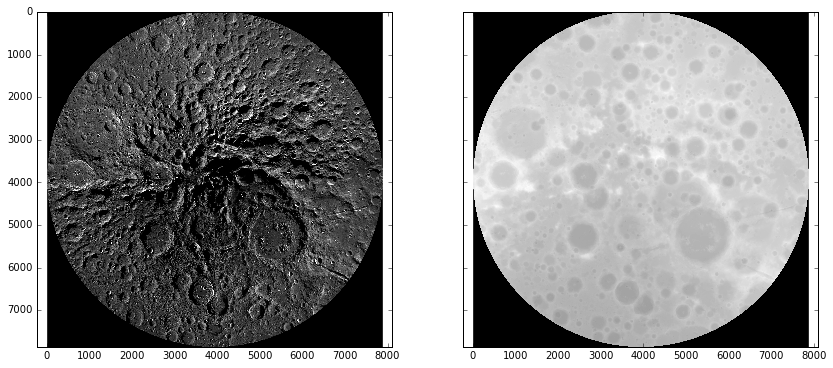

In [39]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
ax1.imshow(lunar_img_ds.GetRasterBand(1).ReadAsArray(), cmap='gray', clim=(0.0,0.2))
ax2.imshow(lunar_elev_ds.GetRasterBand(1).ReadAsArray(), cmap='gray')

# Keep in mind

At this point, we've just been treating these data as `numpy` arrays.  The images on the previous slide line up because the source data products are the same size and have the same bounds.  We been working entirely in **image coordinates**.  We'll think about **geodetic locations** (latitude and longitude) next.

# Extract elevation data from DEM for given lat/lon

The DEM contains elevation information.  A natural question to ask would be: "How can I get the elevation for a given 
location?"  The function below does this, with a caveat.

In [41]:
def elev(lat, lon, ds):
    band = ds.GetRasterBand(1)
    it = gdal.InvGeoTransform(ds.GetGeoTransform())

    moon_srs = osr.SpatialReference()
    moon_srs.ImportFromWkt(ds.GetProjection())
    wgs84_srs = osr.SpatialReference()
    wgs84_srs.SetWellKnownGeogCS('WGS84')

    wgs84_to_moon_transform = \
        osr.CoordinateTransformation(wgs84_srs, moon_srs)
    moon_lon, moon_lat = \
        wgs84_to_moon_transform.TransformPoint(lon, lat)[:2]

    # Convert from moon coordinates to image coordinates
    x, y = gdal.ApplyGeoTransform(it, moon_lon, moon_lat)
    return struct.unpack('h', band.ReadRaster(int(x), int(y), 1, 1, 1, 1, band.DataType))[0]

In [55]:
def elev2(lat, lon, ds):
    band = ds.GetRasterBand(1)
    it = gdal.InvGeoTransform(ds.GetGeoTransform())

    # Convert from moon coordinates to image coordinates
    x, y = gdal.ApplyGeoTransform(it, lon + 90.0, lat)
    return struct.unpack('h', band.ReadRaster(int(x), int(y), 1, 1, 1, 1, band.DataType))[0]

# Let's check out the results

In [56]:
lon = 37.12983
lat = -85.27684
# lunar_elev_ds is our GDAL data set from above
elev2(lat, lon, lunar_elev_ds)

1298

# Gotchas

While, this returned the right value, there is a considerable gotcha

* The coordinate system of the 'WGS84', it should be 'MOON2000'
* Converting from Lat/Lon to X/Y works but attempts to measure
  surface distances would return the wrong value
* The only think the conversion is actually doing is changing
  from a -180°/180° system to 0°/360° system (or vise versa)
* The 'h' argument to struct should be mapped to the `band.DataType`

I am still working to sort this out.  But lets proceed, knowing
our current limitations.

#   Get raster data for lat/lon values from CSV

Check out the included CSV file, it has `time`, `lat`, `lon` in it, also an empty `elev` column, let's pretend I did that delibrately ;)

In [11]:
! head oneday.csv

time,lat,lon,elev
2019-12-22 01:02:17,-60.073,142.861,
2019-12-22 01:02:18,-60.137,142.861,
2019-12-22 01:02:19,-60.201,142.861,
2019-12-22 01:02:20,-60.265,142.861,
2019-12-22 01:02:21,-60.32899999999999,142.861,
2019-12-22 01:02:22,-60.393,142.861,
2019-12-22 01:02:23,-60.457,142.861,
2019-12-22 01:02:24,-60.522,142.861,
2019-12-22 01:02:25,-60.58600000000001,142.862,


Loading the CSV with pandas ...

In [12]:
elevations = pd.read_csv('oneday.csv', index_col=0, parse_dates=True)
elevations.head()

,lat,lon,elev
time,,,
2019-12-22 01:02:17,-60.073,142.861,NaN
2019-12-22 01:02:18,-60.137,142.861,NaN
2019-12-22 01:02:19,-60.201,142.861,NaN
2019-12-22 01:02:20,-60.265,142.861,NaN
2019-12-22 01:02:21,-60.329,142.861,NaN


# Adding the elevation column

Let's use our `elev` function above to populate the missing `elev` column in the dataframe.

In [13]:
elevations['elev'] = list(
    map(elev, elevations['lat'], elevations['lon'],
        repeat(lunar_elev_ds)
       )
    )

# Check out the updated dataframe

In [14]:
elevations.head()

,lat,lon,elev
time,,,
2019-12-22 01:02:17,-60.073,142.861,-4260
2019-12-22 01:02:18,-60.137,142.861,-4077
2019-12-22 01:02:19,-60.201,142.861,-3947
2019-12-22 01:02:20,-60.265,142.861,-3701
2019-12-22 01:02:21,-60.329,142.861,-3557


# Plot the elevation data

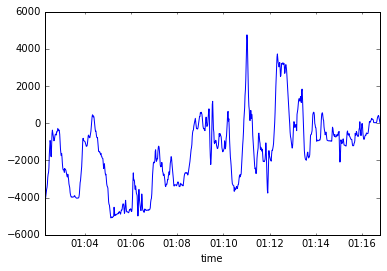

In [15]:
elevations['elev'].plot()

# Display image raster using basemap

TODO

In [16]:
img = lunar_img_ds.GetRasterBand(1).ReadAsArray()
img

array([[ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       ..., 
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38],
       [ -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38, ...,
         -3.40282266e+38,  -3.40282266e+38,  -3.40282266e+38]], dtype=float32)

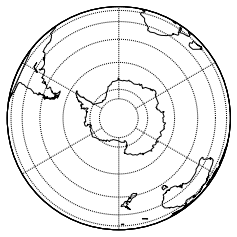

In [17]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

m = Basemap(projection='ortho', lon_0=0, lat_0=-90)
m.drawcoastlines()
m.drawparallels(np.arange(-90., 90., 15.))
m.drawmeridians(np.arange(0., 360., 60.))
plt.show()

# Display image raster with path using basemap

TODO

# Open CSV convert lat/lon to shapefile path

# References

Browse the super lunar data from LROC at ASU, there's lots of data, you can start with the "RDRs" though (WARNING, they have on the order of a petabyte of data):

http://wms.lroc.asu.edu/lroc/rdr_product_select

QGIS Docs are excellent, provide a good introduction to GIS and best of all, QGIS can be extended using Python:

http://docs.qgis.org/2.0/en/docs/index.html